In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, Dropout, LSTM, Activation
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras import backend

# from tensorflow.python.framework import ops
# ops.reset_default_graph()

# tensorflow version and keras version matters for compatability (latest versions not working together tensorflow 2.0 and keras 2.2.4)
# error message - AttributeError: module 'tensorflow' has no attribute 'get_default_graph'
# tensorflow 1.13.1 and keras 2.2.4 worked below

Using TensorFlow backend.


In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect
from sqlalchemy import desc

In [5]:
engine = create_engine("sqlite:///db/Veggie_Fruit_DB.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [8]:
inspector=inspect(engine)
inspector.get_table_names()

['fruitexportdest',
 'fruitexportval',
 'fruitimportsource',
 'fruitimportval',
 'veggieexportdest',
 'veggieexportval',
 'veggieimportsource',
 'veggieimportval']

In [9]:
measurement_columns = inspector.get_columns('fruitexportval')
for c in measurement_columns:
    print(c['name'])

id
product
flow
mktyr
avg
jan
feb
mar
apr
may
jun
jul
aug
sep
oct
nov
dec


In [10]:
# Save references to each table
# FED = FruistExportDestination, FEV =FruitExportValue, FIS =FruitImportSource,FIV=FruitImportValue
# VED =VeggieExportDestination, VEV=VeggieExportValue, VIS=VeggieImportSource, VIV=VeggieImportValue
FED = Base.classes.fruitexportdest
FEV = Base.classes.fruitexportval
FIS = Base.classes.fruitimportsource
FIV = Base.classes.fruitimportval
VED = Base.classes.veggieexportdest
VEV = Base.classes.veggieexportval
VIS = Base.classes.veggieimportsource
VIV = Base.classes.veggieimportval


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [12]:
fev_summary = session.query(FEV).statement
fev_summary_df = pd.read_sql_query(fev_summary, con = engine)
fev_summary_df.head()

,id,product,flow,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1,Apple,Export Value,2019.0,"22,119","89,081","84,166","92,180",0,0,0,0,0,0,0,0,0
1,2,Apple,Export Value,2018.0,"84,095","113,635","99,632","117,936","101,534","108,920","82,645","53,459","51,337","48,029","61,213","89,904","80,895"
2,3,Apple,Export Value,2017.0,"80,792","84,874","87,895","95,203","74,945","82,806","76,525","56,665","53,621","55,600","75,074","127,769","98,522"
3,4,Apple,Export Value,2016.0,"76,723","80,501","87,112","84,530","77,437","76,002","62,334","52,341","56,738","53,495","80,845","108,754","100,586"
4,5,Apple,Export Value,2015.0,"84,888","111,979","83,135","101,106","90,883","99,848","71,933","69,759","67,186","59,125","81,440","99,990","82,272"


In [13]:
fev_df = fev_summary_df.drop('id', axis = 1)
fev_df = fev_df.replace({',':''}, regex = True)
fev_df = fev_df.dropna(how = 'any')
fev_df.count()

product    106
flow       106
mktyr      106
avg        106
jan        106
feb        106
mar        106
apr        106
may        106
jun        106
jul        106
aug        106
sep        106
oct        106
nov        106
dec        106
dtype: int64

In [14]:
fev_number = fev_df.columns[3:]
for i in range(0, len(fev_number)):
    fev_df[fev_number[i]] = pd.to_numeric(fev_df[fev_number[i]])

In [15]:
vev_summary = session.query(VEV).order_by(VEV.product.asc()).statement
vev_df = pd.read_sql_query(vev_summary, con = engine)
vev_df.head()

,id,product,flow,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
0,1,artichoke,Export value,2019.0,70.083333,265,330,246,0,0,0,0,0,0,0,0,0
1,2,artichoke,Export value,2018.0,268.083333,323,366,235,268,326,269,179,187,206,195,334,329
2,3,artichoke,Export value,2017.0,295.916667,258,293,287,262,301,339,257,220,262,399,230,443
3,4,artichoke,Export value,2016.0,275.083333,122,230,295,449,182,306,262,167,269,296,332,391
4,5,artichoke,Export value,2015.0,261.916667,231,373,352,332,320,260,292,216,134,206,230,197


In [16]:
vev_df = vev_df.drop('id', axis = 1)
vev_df = vev_df.replace({',':''}, regex = True)
vev_df = vev_df.dropna(how = 'any')
vev_df.count()

product    50
flow       50
mktyr      50
avg        50
jan        50
feb        50
mar        50
apr        50
may        50
jun        50
jul        50
aug        50
sep        50
oct        50
nov        50
dec        50
dtype: int64

In [17]:
vev_number = vev_df.columns[3:]
for i in range(0, len(vev_number)):
    vev_df[vev_number[i]] = pd.to_numeric(vev_df[vev_number[i]])

In [18]:
e_frames = [vev_df, fev_df]
export_all = pd.concat(e_frames,ignore_index=False)

In [19]:
export_all.dtypes

product     object
flow        object
mktyr      float64
avg        float64
jan        float64
feb        float64
mar        float64
apr        float64
may        float64
jun        float64
jul        float64
aug        float64
sep        float64
oct        float64
nov        float64
dec        float64
dtype: object

In [20]:
export_month = export_all.columns
export_month = export_month[4:]
for i in range(0, len(export_month)):
    export_all[export_month[i]] = pd.to_numeric(export_all[export_month[i]])
    
export_all['year_sum'] = export_all['jan'] + export_all['feb']

for j in range(2, len(export_month)-1):
    export_all['year_sum'] += export_all[export_month[j]]
    
export_all.head()

,product,flow,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
0,artichoke,Export value,2019.0,70.083333,265.0,330.0,246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,841.0
1,artichoke,Export value,2018.0,268.083333,323.0,366.0,235.0,268.0,326.0,269.0,179.0,187.0,206.0,195.0,334.0,329.0,2888.0
2,artichoke,Export value,2017.0,295.916667,258.0,293.0,287.0,262.0,301.0,339.0,257.0,220.0,262.0,399.0,230.0,443.0,3108.0
3,artichoke,Export value,2016.0,275.083333,122.0,230.0,295.0,449.0,182.0,306.0,262.0,167.0,269.0,296.0,332.0,391.0,2910.0
4,artichoke,Export value,2015.0,261.916667,231.0,373.0,352.0,332.0,320.0,260.0,292.0,216.0,134.0,206.0,230.0,197.0,2946.0


In [21]:
export_specific = export_all.set_index("product")
broccoli_overall = export_specific.loc['broccoli', :]
#len(broccoli_overall['mktyr'])
#len(export_month[:-1])
broccoli_overall

,flow,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
product,,,,,,,,,,,,,,,,
broccoli,Export value,2019.0,1932.916667,7926.0,6978.0,8291.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23195.0
broccoli,Export value,2018.0,8727.750000,9423.0,8442.0,9187.0,10525.0,9467.0,9664.0,6865.0,6891.0,8128.0,8400.0,8584.0,9157.0,95576.0
broccoli,Export value,2017.0,8179.166667,8472.0,8197.0,8164.0,8933.0,9908.0,10528.0,7474.0,6586.0,5626.0,5586.0,9204.0,9472.0,88678.0
broccoli,Export value,2016.0,9971.833333,11011.0,8768.0,11019.0,13129.0,11740.0,10830.0,7156.0,7584.0,9029.0,10145.0,10362.0,8889.0,110773.0
broccoli,Export value,2015.0,9996.833333,10521.0,9769.0,10227.0,13467.0,13274.0,11550.0,8444.0,7708.0,8022.0,8552.0,8111.0,10317.0,109645.0


In [22]:
export_all['product'].unique()

array(['artichoke', 'beet', 'broccoli', 'carrot', 'green pea', 'mushroom',
       'onion', 'pepper', 'potato', 'sweet corn', 'Apple', 'Apricot',
       'Avocados', 'Blueberries', 'Cherries', 'Citrus', 'Cranberries',
       'Figs', 'Grapefruit', 'Grapes', 'Guavas', 'Kiwi', 'Limes',
       'Orange', 'Papaya', 'Peaches', 'Pears', 'Persimmons', 'Pineapples',
       'Plums', 'Strawberries', 'Tangerines'], dtype=object)

In [23]:
broccoli_specific = broccoli_overall.reset_index(drop = True)
broccoli_specific

,flow,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
0,Export value,2019.0,1932.916667,7926.0,6978.0,8291.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23195.0
1,Export value,2018.0,8727.750000,9423.0,8442.0,9187.0,10525.0,9467.0,9664.0,6865.0,6891.0,8128.0,8400.0,8584.0,9157.0,95576.0
2,Export value,2017.0,8179.166667,8472.0,8197.0,8164.0,8933.0,9908.0,10528.0,7474.0,6586.0,5626.0,5586.0,9204.0,9472.0,88678.0
3,Export value,2016.0,9971.833333,11011.0,8768.0,11019.0,13129.0,11740.0,10830.0,7156.0,7584.0,9029.0,10145.0,10362.0,8889.0,110773.0
4,Export value,2015.0,9996.833333,10521.0,9769.0,10227.0,13467.0,13274.0,11550.0,8444.0,7708.0,8022.0,8552.0,8111.0,10317.0,109645.0


In [24]:
export_all_refined = export_all.drop("flow", axis = 1)
export_all_refined.head()

,product,mktyr,avg,jan,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec,year_sum
0,artichoke,2019.0,70.083333,265.0,330.0,246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,841.0
1,artichoke,2018.0,268.083333,323.0,366.0,235.0,268.0,326.0,269.0,179.0,187.0,206.0,195.0,334.0,329.0,2888.0
2,artichoke,2017.0,295.916667,258.0,293.0,287.0,262.0,301.0,339.0,257.0,220.0,262.0,399.0,230.0,443.0,3108.0
3,artichoke,2016.0,275.083333,122.0,230.0,295.0,449.0,182.0,306.0,262.0,167.0,269.0,296.0,332.0,391.0,2910.0
4,artichoke,2015.0,261.916667,231.0,373.0,352.0,332.0,320.0,260.0,292.0,216.0,134.0,206.0,230.0,197.0,2946.0


In [25]:
fed_summary = session.query(FED).statement
fed_summary_df = pd.read_sql_query(fed_summary, con = engine)
fed_summary_df.drop(['id', 'flow', 'lat', 'lon'], axis=1, inplace=True)
fed_summary_df.head()

,product,country,share,avg,yr15,yr16,yr17,yr18,yr19
0,Apple,Mexico,26.40%,"269,127","230,643","265,054","289,339","175,074","152,300"
1,Apple,Canada,17.10%,"176,116","190,958","171,046","167,337","107,007","92,426"
2,Apple,India,10.10%,"106,973","56,484","89,033","174,179","90,591","40,340"
3,Apple,Taiwan,8.10%,"79,069","76,072","83,912","67,184","64,703","61,365"
4,Apple,Vietnam,4.40%,"38,827","29,789","36,508","41,656","37,473","47,310"


In [26]:
fed_summary_df = fed_summary_df.replace({'%':'', ',':''}, regex=True)
fed_number = fed_summary_df.columns[2:]
for i in range(0, len(fed_number)):
    fed_summary_df[fed_number[i]] = pd.to_numeric(fed_summary_df[fed_number[i]])
fed_summary_df.head()

,product,country,share,avg,yr15,yr16,yr17,yr18,yr19
0,Apple,Mexico,26.4,269127.0,230643.0,265054.0,289339.0,175074.0,152300.0
1,Apple,Canada,17.1,176116.0,190958.0,171046.0,167337.0,107007.0,92426.0
2,Apple,India,10.1,106973.0,56484.0,89033.0,174179.0,90591.0,40340.0
3,Apple,Taiwan,8.1,79069.0,76072.0,83912.0,67184.0,64703.0,61365.0
4,Apple,Vietnam,4.4,38827.0,29789.0,36508.0,41656.0,37473.0,47310.0


In [27]:
taiwan_fruit_summary = fed_summary_df.loc[fed_summary_df['country'] == 'Taiwan', :]
taiwan_fruit_summary.reset_index(drop = True).head()

,product,country,share,avg,yr15,yr16,yr17,yr18,yr19
0,Apple,Taiwan,8.1,79069.0,76072.0,83912.0,67184.0,64703.0,61365.0
1,Apricot,Taiwan,0.6,59.0,113.0,36.0,60.0,0.0,0.0
2,Avocado,Taiwan,2.8,877.0,500.0,651.0,2300.0,647.0,668.0
3,Blueberries,Taiwan,1.3,1237.0,808.0,885.0,1149.0,0.0,13.0
4,Cherries,Taiwan,8.8,34926.0,39553.0,54364.0,49987.0,0.0,0.0


In [28]:
broccoli_month_list = []
result_2019 = broccoli_specific.iloc[0,3:6]

length = len(broccoli_specific.mktyr) - 1
while length > 0:
    result_rest = broccoli_specific.iloc[length,3:15]
    for r in range(0, len(result_rest)):
        broccoli_month_list.append(result_rest[r])
    length -= 1

#2019 first 3 months:
for i in range(0, len(result_2019)):
    broccoli_month_list.append(result_2019[i])

month = [m for m in range(1, len(broccoli_month_list) + 1)]
broccoli_export_df = pd.DataFrame({"month": month, "broccoli": broccoli_month_list})
result_rest

jan     9423
feb     8442
mar     9187
apr    10525
may     9467
jun     9664
jul     6865
aug     6891
sep     8128
oct     8400
nov     8584
dec     9157
Name: 1, dtype: object

In [29]:
training_set = broccoli_export_df["broccoli"].values.reshape(-1, 1)

X_scaler = MinMaxScaler().fit(training_set)
training_set_scaled = X_scaler.transform(training_set)

X_train = []
y_train = []

for i in range(5, 51):
    X_train.append(training_set_scaled[i-5:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

(46, 5, 1) (46, 1)


In [30]:
X_test = []
y_test = []

for i in range(5, 11):
    X_test.append(training_set_scaled[i-5:i])
    y_test.append(training_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(6, 5, 1)


In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 10)             480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense (Dense)                (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________
Train on 46 samples, validate on 6 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/65
46/46 [==============================] - 2s 40ms/sample - loss: 0.1922 - mean_squared_error: 0.1922 - val_loss: 0.1239 - val_mean_squared_error: 0.1239
Epoch 2/65
46/46 [============

46/46 [==============================] - 0s 2ms/sample - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0258 - val_mean_squared_error: 0.0258
Epoch 42/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0392 - mean_squared_error: 0.0392 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 43/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0403 - mean_squared_error: 0.0403 - val_loss: 0.0269 - val_mean_squared_error: 0.0269
Epoch 44/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0268 - val_mean_squared_error: 0.0268
Epoch 45/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0261 - val_mean_squared_error: 0.0261
Epoch 46/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0387 - mean_squared_error: 0.0387 - val_loss: 0.0266 - val_mean_squared_error: 0.0266
Epoch 47/65
46/46 [===============

In [32]:
predicted_broccoli_price = model.predict(X_test)
predicted_broccoli_price.shape

(6, 1)

In [33]:
broccoli_prediction = X_scaler.inverse_transform(predicted_broccoli_price)
broccoli_price = X_scaler.inverse_transform(y_test)
broccoli_price_list = broccoli_price.tolist()
#print(y_test[:5])
type(round(float(broccoli_prediction[5]),2))

float

In [34]:
model_loss = model.evaluate(X_test, y_test, verbose=2)
#print(f"Normal Neural Network - Loss: {round(model_loss,4)}")
type(model_loss)

 - 0s - loss: 0.0233 - mean_squared_error: 0.0233


list

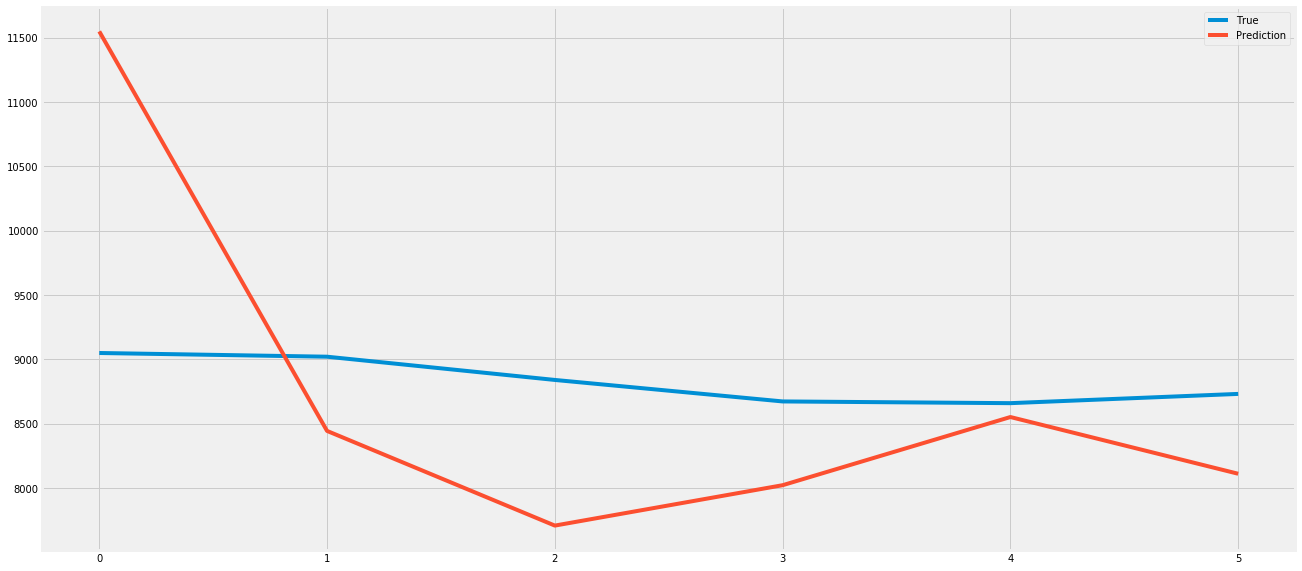

In [35]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(broccoli_prediction, label='True')
ax.plot(broccoli_price, label='Prediction')
ax.legend()
plt.show()

In [36]:
apple_overall = export_specific.loc['Cherries', :]
apple_specific = apple_overall.reset_index(drop = True)
apple_month_list = []
result_2019 = apple_specific.iloc[0,3:6]

length = len(apple_specific.mktyr) - 1
while length > 0:
    result_rest = apple_specific.iloc[length,3:15]
    for r in range(0, len(result_rest)):
        apple_month_list.append(result_rest[r])
    length -= 1

#2019 first 3 months:
for i in range(0, len(result_2019)):
    apple_month_list.append(result_2019[i])

month = [m for m in range(1, len(apple_month_list) + 1)]
apple_export_df = pd.DataFrame({"month": month, "Cherries": apple_month_list})
apple_export_df

,month,Cherries
0,1,305.0
1,2,75.0
2,3,0.0
3,4,6094.0
4,5,110336.0
5,6,172970.0
6,7,130223.0
7,8,1233.0
8,9,31.0
9,10,6.0


In [37]:
training_set = apple_export_df["Cherries"].values.reshape(-1, 1)

X_scaler = MinMaxScaler().fit(training_set)
training_set_scaled = X_scaler.transform(training_set)

X_train = []
y_train = []

for i in range(5, 51):
    X_train.append(training_set_scaled[i-5:i])
    y_train.append(training_set_scaled[i])
X_train, y_train = np.array(X_train), np.array(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

print(X_train.shape, y_train.shape)

(46, 5, 1) (46, 1)


In [38]:
X_test = []
y_test = []

for i in range(5, 11):
    X_test.append(training_set_scaled[i-5:i])
    y_test.append(training_set_scaled[i])
X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(6, 5, 1)


In [39]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(X_train.shape[1], 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 5, 10)             480       
_________________________________________________________________
lstm_3 (LSTM)                (None, 24)                3360      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 3,865
Trainable params: 3,865
Non-trainable params: 0
_________________________________________________________________
Train on 46 samples, validate on 6 samples
Epoch 1/65
46/46 [==============================] - 2s 41ms/sample - loss: 0.1024 - mean_squared_error: 0.1024 - val_loss: 0.1087 - val_mean_squared_error: 0.1087
Epoch 2/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0918 - mean_squared_error: 0.0918 - val_loss: 0.0981 - val_mean_squared_error: 0.0981
Epoch 3/65
46/46 [==================

46/46 [==============================] - 0s 2ms/sample - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0362 - val_mean_squared_error: 0.0362
Epoch 47/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0489 - mean_squared_error: 0.0489 - val_loss: 0.0352 - val_mean_squared_error: 0.0352
Epoch 48/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0335 - val_mean_squared_error: 0.0335
Epoch 49/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0450 - mean_squared_error: 0.0450 - val_loss: 0.0315 - val_mean_squared_error: 0.0315
Epoch 50/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.0284 - val_mean_squared_error: 0.0284
Epoch 51/65
46/46 [==============================] - 0s 2ms/sample - loss: 0.0426 - mean_squared_error: 0.0426 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 52/65
46/46 [===============

In [40]:
predicted_apple_price = model.predict(X_test)
apple_prediction = X_scaler.inverse_transform(predicted_apple_price)
apple_price = X_scaler.inverse_transform(y_test)
print(apple_price[:10])
print(apple_prediction[:10])

[[1.72970e+05]
 [1.30223e+05]
 [1.23300e+03]
 [3.10000e+01]
 [6.00000e+00]
 [2.10000e+02]]
[[1.6428547e+05]
 [1.9171236e+05]
 [8.3177666e+03]
 [4.0549751e+03]
 [3.8320476e+03]
 [1.4780237e+02]]


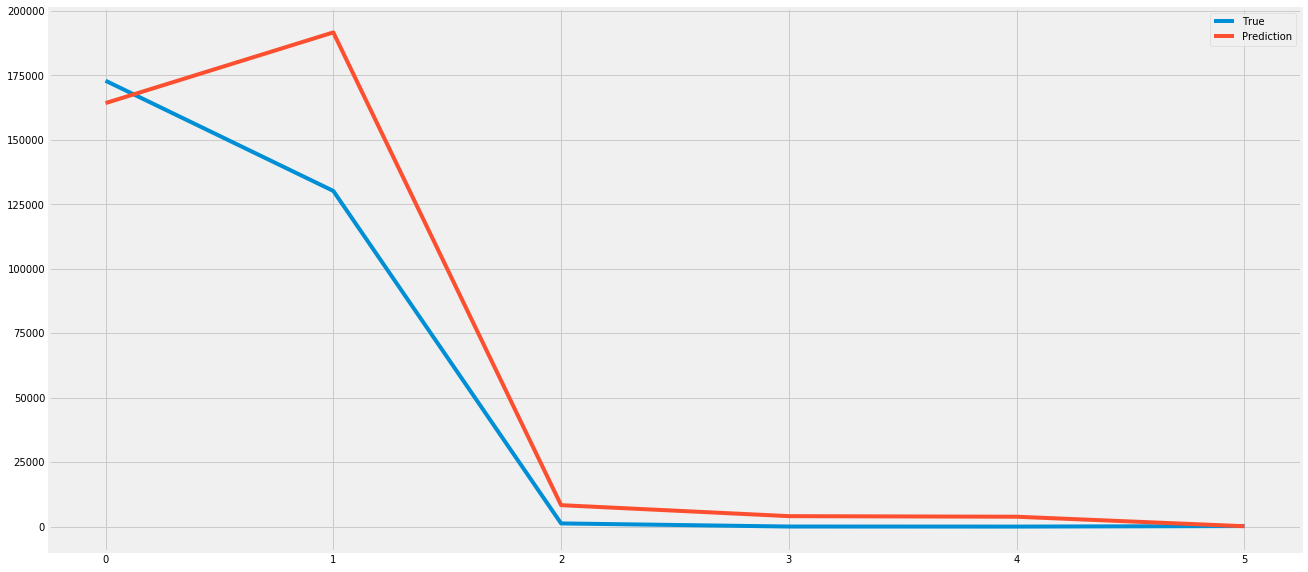

In [41]:
fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(apple_price, label='True')
ax.plot(apple_prediction, label='Prediction')
ax.legend()
plt.show()

In [42]:

# #creating dataframe
# onn_dt = onn_data.sort_index(ascending=True, axis=0)

# new_onn_dt = pd.DataFrame(index=range(0,len(onn_dt)),columns=['mo', 'value'])
# for i in range(0,len(onn_dt)):
#     new_onn_dt['mo'][i] = new_onn_dt['mo'][i]
#     new_onn_dt['value'][i] = new_onn_dt['value'][i]

#     #setting index
# new_onn_dt.index = new_onn_dt.mo
# new_onn_dt.drop('mo', axis=1, inplace=True)
# new_onn_dt
onn_fin=onn_data[["mo", "value"]]

NameError: name 'onn_data' is not defined

In [ ]:
onn_fin.index = onn_fin.mo
onn_fin.drop('mo', axis=1, inplace=True)
onn_fin.head()


In [ ]:
value = onn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
pepper_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')]
pepp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pepper')].reset_index()
pepp_2015_new = pepp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2015 = pepp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pepp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pepp_2016_new = pepp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2016 = pepp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pepp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pepp_2017_new = pepp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2017 = pepp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pepp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pepp_2018_new = pepp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pepp_2018 = pepp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pepp = ren_pepp_2015.join([ren_pepp_2016, ren_pepp_2017, ren_pepp_2018], how='outer')


In [ ]:

trans_pepp = pepp.T 
pepp_final = trans_pepp.reset_index()
pepp_data = pepp_final.rename(columns={"index": "month", 0: "value"})
pepp_data['mo'] = pepp_data.index
pepp_fin=pepp_data[["mo", "value"]]
pepp_fin.index = pepp_fin.mo
pepp_fin.drop('mo', axis=1, inplace=True)
pepp_fin.head()


In [ ]:
value = pepp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
potato_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')]
pot_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pot_2015_new = pot_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2015 = pot_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pot_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pot_2016_new = pot_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2016 = pot_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pot_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pot_2017_new = pot_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2017 = pot_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pot_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pot_2018_new = pot_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pot_2018 = pot_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pot = ren_pot_2015.join([ren_pot_2016, ren_pot_2017, ren_pot_2018], how='outer')


In [ ]:
trans_pot = pot.T 
pot_final = trans_pot.reset_index()
pot_data = pot_final.rename(columns={"index": "month", 0: "value"})
pot_data['mo'] = pot_data.index
pot_fin=pot_data[["mo", "value"]]
pot_fin.index = pot_fin.mo
pot_fin.drop('mo', axis=1, inplace=True)
pot_fin.head()


In [ ]:
value = pot_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
# model.fit(x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
apple_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Apple')]
app_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
app_2015_new = app_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2015 = app_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
app_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
app_2016_new = app_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2016 = app_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
app_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
app_2017_new = app_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2017 = app_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
app_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
app_2018_new = app_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_app_2018 = app_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
app = ren_app_2015.join([ren_app_2016, ren_app_2017, ren_app_2018], how='outer')


In [ ]:
trans_app = app.T 
app_final = trans_app.reset_index()
app_data = app_final.rename(columns={"index": "month", 0: "value"})
app_data['mo'] = app_data.index
app_fin=app_data[["mo", "value"]]
app_fin.index = app_fin.mo
app_fin.drop('mo', axis=1, inplace=True)
app_fin.head()

In [ ]:
value = app_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
# model.fit(x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
grapes_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Grapes')]
grp_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
grp_2015_new = grp_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2015 = grp_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
grp_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
grp_2016_new = grp_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2016 = grp_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
grp_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
grp_2017_new = grp_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2017 = grp_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
grp_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
grp_2018_new = grp_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_grp_2018 = grp_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
grp = ren_grp_2015.join([ren_grp_2016, ren_grp_2017, ren_grp_2018], how='outer')


In [ ]:
trans_grp = grp.T 
grp_final = trans_grp.reset_index()
grp_data = grp_final.rename(columns={"index": "month", 0: "value"})
grp_data['mo'] = grp_data.index
grp_fin=grp_data[["mo", "value"]]
grp_fin.index = grp_fin.mo
grp_fin.drop('mo', axis=1, inplace=True)
grp_fin.head()

In [ ]:
value = grp_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
# model.fit(x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
orange_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Orange')]
orn_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
orn_2015_new = orn_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2015 = orn_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
orn_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
orn_2016_new = orn_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2016 = orn_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
orn_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
orn_2017_new = orn_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2017 = orn_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
orn_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
orn_2018_new = orn_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_orn_2018 = orn_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
orn = ren_orn_2015.join([ren_orn_2016, ren_orn_2017, ren_orn_2018], how='outer')


In [ ]:
trans_orn = orn.T 
orn_final = trans_orn.reset_index()
orn_data = orn_final.rename(columns={"index": "month", 0: "value"})
orn_data['mo'] = orn_data.index
orn_fin=orn_data[["mo", "value"]]
orn_fin.index = orn_fin.mo
orn_fin.drop('mo', axis=1, inplace=True)
orn_fin.head()

In [ ]:
value = orn_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
# model.fit(x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
pears_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Pears')]
pr_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
pr_2015_new = pr_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2015 = pr_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
pr_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
pr_2016_new = pr_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2016 = pr_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
pr_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
pr_2017_new = pr_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2017 = pr_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
pr_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
pr_2018_new = pr_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_pr_2018 = pr_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
pr = ren_pr_2015.join([ren_pr_2016, ren_pr_2017, ren_pr_2018], how='outer')


In [ ]:
trans_pr = pr.T 
pr_final = trans_pr.reset_index()
pr_data = pr_final.rename(columns={"index": "month", 0: "value"})
pr_data['mo'] = pr_data.index
pr_fin=pr_data[["mo", "value"]]
pr_fin.index = pr_fin.mo
pr_fin.drop('mo', axis=1, inplace=True)
pr_fin.head()

In [ ]:
value = pr_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
# model.fit(x_train, y_train,
#     validation_data=(x_test, y_test),
#     batch_size=10,
#     epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()

In [ ]:
strawberries_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Strawberries')]
str_2015 = export_all[(export_all['mktyr'] == 2015.0) & (export_all['product']=='Potato')].reset_index()
str_2015_new = str_2015[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2015 = str_2015_new.rename(columns={"jan":"m1", "feb":"m2", "mar":"m3", "apr":"m4", "may":"m5", "jun":"m6", "jul":"m7","aug":"m8","sep":"m9","oct":"m10","nov":"m11", "dec":"m12"})
str_2016 = export_all[(export_all['mktyr'] == 2016.0) & (export_all['product']=='Onion')].reset_index()
str_2016_new = str_2016[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2016 = str_2016_new.rename(columns={"jan":"m13", "feb":"m14", "mar":"m15", "apr":"m16", "may":"m17", "jun":"m18", "jul":"m19","aug":"m20","sep":"m21","oct":"m22","nov":"m23", "dec":"m24"})
str_2017 = export_all[(export_all['mktyr'] == 2017.0) & (export_all['product']=='Onion')].reset_index()
str_2017_new = str_2017[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2017 = str_2017_new.rename(columns={"jan":"m25", "feb":"m26", "mar":"m27", "apr":"m28", "may":"m29", "jun":"m30", "jul":"m31","aug":"m32","sep":"m33","oct":"m34","nov":"m35", "dec":"m36"})
str_2018 = export_all[(export_all['mktyr'] == 2018.0) & (export_all['product']=='Onion')].reset_index()
str_2018_new = str_2018[['jan','feb', 'mar','apr','may','jun','jul','aug','sep','oct', 'nov', 'dec']]
ren_str_2018 = str_2018_new.rename(columns={"jan":"m37", "feb":"m38", "mar":"m39", "apr":"m40", "may":"m41", "jun":"m42", "jul":"m43","aug":"m44","sep":"m45","oct":"m46","nov":"m47", "dec":"m48"})
strw = ren_str_2015.join([ren_str_2016, ren_str_2017, ren_str_2018], how='outer')

In [ ]:
trans_str = strw.T 
str_final = trans_str.reset_index()
str_data = str_final.rename(columns={"index": "month", 0: "value"})
str_data['mo'] = str_data.index
str_fin=str_data[["mo", "value"]]
str_fin.index = str_fin.mo
str_fin.drop('mo', axis=1, inplace=True)
str_fin.head()

In [ ]:
value = str_fin["value"].values
seq_len = 10
sequence_length = seq_len + 1

result = []
for index in range(len(value) - sequence_length):
    result.append(value[index: index + sequence_length])

In [ ]:
normalized_data = []
for window in result:
    normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
    normalized_data.append(normalized_window)

result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0] * 0.9))
train = result[:row, :]
np.random.shuffle(train)

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[row:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[row:, -1]

x_train.shape, x_test.shape

In [ ]:
model = Sequential()

model.add(LSTM(10, return_sequences=True, input_shape=(10, 1)))

model.add(LSTM(24, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', metrics=["mean_squared_error"],optimizer='nadam')

model.summary()

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 65, batch_size = 10)

In [ ]:
model.fit(x_train, y_train,
    validation_data=(x_test, y_test),
    batch_size=10,
    epochs=20)

In [ ]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()